In [1]:
import cv2
import random
import numpy as np
from helpers.limbus_detection import detect_limbus
from helpers.misc import jiggle_circle, tighten_circle, repair_bbox
from helpers.view_detection import get_view_mask
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
kcf_params = cv2.TrackerKCF_Params()
# kcf_params.compressed_size = 1
# kcf_params.desc_pca = cv2.TrackerKCF_GRAY
# kcf_params.desc_npca = cv2.TrackerKCF_GRAY
# kcf_params.resize = True
# kcf_params.detect_thresh = 0.7

csrt_params = cv2.TrackerCSRT_Params()
# csrt_params.psr_threshold = 0.05

def reset_tracker(frame, view_mask=None):
    circle = detect_limbus(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), validation='inout',
                           validation_value_thresh=40, view_mask=view_mask)
    if circle is None:
        return None

    tracker = cv2.TrackerKCF_create(kcf_params)
#     tracker = cv2.TrackerCSRT_create(csrt_params)

    bbox = (round(circle[0] - circle[2]), round(circle[1] - circle[2]), 
            round(circle[2]*2), round(circle[2]*2))
    tracker.init(frame, bbox)
    
    return tracker

In [3]:
# filepath = '/Users/mirek/Desktop/bioniko_input_long.mp4'
filepath = '/Users/mirek/Desktop/test.mp4'
cap = cv2.VideoCapture(filepath)

_, frame = cap.read()
tracker = reset_tracker(frame)

In [4]:
while cap.isOpened():
    # Read a new frame
    ret, frame = cap.read() 
    if ret == False:
        break

    timer = cv2.getTickCount()

#     tracker = reset_tracker(frame)
    if tracker is None:
        ok = False
    else:
        ok, bbox = tracker.update(frame)
        
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    if ok:
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.circle(frame, (round(bbox[0] + bbox[2]/2), round(bbox[1] + bbox[3]/2)),
                   round((bbox[2] + bbox[3])/4), (255,0,0))
        cv2.putText(frame, "width v. height diff: %d" % abs(bbox[2] - bbox[3]),
                    (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                    (0,0,255) if abs(bbox[2] - bbox[3]) > 0 else (0,255,0),2)
        cv2.rectangle(frame, p1, p2, (255,0,0), 2, 1)
    else:
        cv2.putText(frame, "Tracking failure detected", (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
        tracker = reset_tracker(frame)

    if fps < 20:
        tracker = None
        
#     cv2.putText(frame, "KCF Tracker", (100,20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2);
    cv2.putText(frame, "FPS : " + str(int(fps)), (100,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50), 2);
    cv2.imshow("Tracking", frame)

    # Exit if ESC pressed
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

cap.release()                    
cv2.destroyAllWindows() 

### Circle jiggle

In [ ]:
im = cv2.imread('/Users/mirek/Desktop/test2.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.imshow(im, cmap='gray')

In [ ]:
CORRECT_CIRCLE = np.array((265,370,235))
INIT_CIRCLE = np.array((300,300,235))

# CORRECT_CIRCLE = np.array((270,310,185))
# INIT_CIRCLE = np.array((300,300,185))

In [ ]:
im_c = im.copy()
mask = np.zeros(im_c.shape, dtype=np.byte)
cv2.circle(im_c, (INIT_CIRCLE[0], INIT_CIRCLE[1]), INIT_CIRCLE[2], 255, 10)
cv2.circle(mask, (INIT_CIRCLE[0], INIT_CIRCLE[1]), INIT_CIRCLE[2], 1, 10)

_, axs = plt.subplots(1,2)
axs[0].imshow(im_c, cmap='gray')
axs[1].imshow(mask)

In [ ]:
moments = cv2.moments(im*mask, False)
moments

In [ ]:
center = (round(moments['m10']/moments['m00']),
          round(moments['m01']/moments['m00']))
direction = (round(moments['m10']/moments['m00'] - INIT_CIRCLE[0]),
             round(moments['m01']/moments['m00'] - INIT_CIRCLE[1]))
im_cc = im_c.copy()
cv2.drawMarker(im_cc, center, 255, thickness=3)
cv2.line(im_cc, (INIT_CIRCLE[0], INIT_CIRCLE[1]), center, 255, thickness=3)

plt.imshow(im_cc, cmap='gray')

In [ ]:
MAX_ITER = 10
ALPHA = 0.5

iter_ims = [im_c]
circle = np.copy(INIT_CIRCLE).astype('float32')
for _ in range(MAX_ITER):
    # pre edge treatment
    mask = np.zeros(im_c.shape, dtype=np.byte)
    cv2.circle(mask, (round(circle[0]), round(circle[1])), round(circle[2]), 1, 10)
    moments = cv2.moments(im*mask, False)
    
    # edge treatment
    padding = 0
    im_border = None
    if ((0 < round(circle[0]) - round(circle[2]) - 5) or
        (round(circle[0]) + round(circle[2]) + 5 >= im_c.shape[1]) or
        (0 < round(circle[1]) - round(circle[2]) - 5) or
        (round(circle[1]) + round(circle[2]) + 5 >= im_c.shape[0])):
        
        mean_value = moments['m00']/cv2.countNonZero(mask)
        padding = round(circle[2])*2 + 10
        im_border = cv2.copyMakeBorder(im, padding, padding, padding, padding, 
                                       cv2.BORDER_CONSTANT, value=round(mean_value))
        mask = np.zeros(im_border.shape, dtype=np.byte)
        cv2.circle(mask, (round(circle[0]) + padding, round(circle[1]) + padding), round(circle[2]), 1, 10)
        moments = cv2.moments(im_border*mask, False)

    # post edge treatment
    direction = np.array((moments['m10']/moments['m00'] - circle[0] - padding,
                          moments['m01']/moments['m00'] - circle[1] - padding))
    circle[:2] -= ALPHA*direction
    
    im_new = im.copy()
    cv2.circle(im_new, (round(circle[0]), round(circle[1])), round(circle[2]), 255, 10)
    iter_ims.append(im_new)
    
_, axs = plt.subplots(1, len(iter_ims), figsize=(50,10))
for i in range(len(iter_ims)):
    axs[i].imshow(iter_ims[i], cmap='gray')

plt.show()
print('correct ', CORRECT_CIRCLE, '\ndetected ', circle)

### View masking

In [ ]:
im_view = cv2.imread('/Users/mirek/Desktop/test3.png')
im_view = cv2.cvtColor(im_view, cv2.COLOR_BGR2GRAY)
plt.imshow(im_view, cmap='gray')

In [ ]:
circle = detect_limbus(im_view, validation='inout', validation_mode='min')
im_view_c = im_view.copy()
mask = np.zeros(im_view_c.shape, dtype=np.byte)

cv2.circle(im_view_c, (round(circle[0]), round(circle[1])), round(circle[2]), 255, 10)
cv2.circle(mask, (round(circle[0]), round(circle[1])), round(circle[2]), 1, cv2.FILLED)

_, axs = plt.subplots(1, 2)
axs[0].imshow(im_view_c, cmap='gray')
axs[1].imshow(mask, cmap='gray')

### KFC tracking with circle jiggle

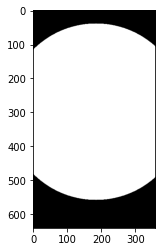

In [3]:
filepath = '/Users/mirek/Desktop/bioniko_input_long.mp4'
cap = cv2.VideoCapture(filepath)

_, frame = cap.read()
view_mask = get_view_mask(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
# tracker = reset_tracker(frame, view_mask=view_mask)
tracker = reset_tracker(frame)

plt.imshow(view_mask, cmap='gray')

In [4]:
while cap.isOpened():
    # Read a new frame
    ret, frame = cap.read() 
    if ret == False:
        break

    timer = cv2.getTickCount()

#     tracker = reset_tracker(frame)
    if tracker is None:
        ok = False
    else:
        ok, bbox = tracker.update(frame)
        
    if ok:
        new_bbox = repair_bbox(bbox, frame.shape[1], frame.shape[0])
        if new_bbox is not None:
            bbox = new_bbox
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        circle = tighten_circle(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), 
                               np.array((bbox[0] + bbox[2]/2, 
                                         bbox[1] + bbox[3]/2, 
                                         (bbox[2] + bbox[3])/4)),
                              view_mask=view_mask)
#         circle = jiggle_circle(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), 
#                                np.array((bbox[0] + bbox[2]/2, 
#                                          bbox[1] + bbox[3]/2, 
#                                          (bbox[2] + bbox[3])/4)),
#                               view_mask=view_mask)

        cv2.circle(frame, (round(circle[0]), round(circle[1])), round(circle[2]), (0,0,255), 1)
        cv2.putText(frame, "width v. height diff: %d" % abs(bbox[2] - bbox[3]),
                    (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                    (0,0,255) if abs(bbox[2] - bbox[3]) > 0 else (0,255,0),2)

        cv2.rectangle(frame, p1, p2, (255,0,0), 1, 1)
    else:
        cv2.putText(frame, "Tracking failure detected", (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
        tracker = reset_tracker(frame, view_mask=view_mask)
#         tracker = reset_tracker(frame)

    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    if fps < 10:
        tracker = None
        
    cv2.putText(frame, "KCF Tracker", (100,20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2);
    cv2.putText(frame, "FPS : " + str(int(fps)), (100,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50), 2);
    cv2.imshow("Tracking", frame)

    # Exit if ESC pressed
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

cap.release()                    
cv2.destroyAllWindows() 

### Tracking by detection fallback

In [2]:
filepath = '/Users/mirek/Desktop/bioniko_input_long.mp4'
cap = cv2.VideoCapture(filepath)

In [3]:
while cap.isOpened():
    # Read a new frame
    ret, frame = cap.read() 
    if ret == False:
        break
        
    timer = cv2.getTickCount()
    circle = detect_limbus(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), validation='inout',
                           validation_value_thresh=40)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    
    if circle is not None:
        cv2.circle(frame, (round(circle[0]), round(circle[1])), round(circle[2]), (0,0,255), 1)
    cv2.putText(frame, "FPS : " + str(int(fps)), (100,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50), 2);
    cv2.imshow("Tracking", frame)

    # Exit if ESC pressed
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

cap.release()                    
cv2.destroyAllWindows() 